# Character-level entropy: reproducing results from Shannon (1951)
In this notebook, we will explore the computation of various flavors of entropy using natural language as a test-bed.  We will perform these explorations at the level of characters (although an interesting analysis can also be done at the word level).

## Part 1: The baseline
As a matter of comparison, and in order to get a sense of the magnitude of the entropy numbers that we expect to be dealing with, let's compute the entropy of the alphabet under the assumption that each character is independent and uniformly distributed.  As our alphabet, let's take the 26 letters (A-Z), the digits (0-9), and the space character.  Ignore case and punctuation.  Derive the simplest expression that you can for the entropy of this distribution for a single character.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
alphanumeric_chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', 'a', 'b', 'c', 'd', 'e', 'f',
                     'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v',
                     'w', 'x', 'y', 'z']
total_chars = len(alphanumeric_chars)
entropy = np.log2(total_chars)
print(f"Entropy of alphanumeric characters: {entropy:.2f} bits per character")

Entropy of alphanumeric characters: 5.21 bits per character


## Part 2: Unigram entropy
Next, we will consider the character-level entropy of natural english.  In words, our task is as follows: given some character drawn from a corpus of English text, how many yes or no questions do I need to ask on average to figure out the character, assuming questions are asked optimally?  To compute the entropy, we need a text on which to base our estimates of frequency.  Python's [Natural Language Toolkit (NLTK)](https://www.nltk.org) is a nice tool for this purpose.  We'll look at a few different text corpi (the others being the Book of Genesis and a spanish-language corpus_, starting with the 'Brown dataset', which is around 1M words long, and was compiled at Brown University from a large number of newspaper articles.  First, install nltk via pip (or whatever), then we can acquire the corpus as  

In [3]:
import nltk
nltk.download('brown')
nltk.download('genesis')
nltk.download('cess_esp')

from nltk.corpus import brown,genesis,cess_esp
print(brown.sents())

[['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.'], ['The', 'jury', 'further', 'said', 'in', 'term-end', 'presentments', 'that', 'the', 'City', 'Executive', 'Committee', ',', 'which', 'had', 'over-all', 'charge', 'of', 'the', 'election', ',', '``', 'deserves', 'the', 'praise', 'and', 'thanks', 'of', 'the', 'City', 'of', 'Atlanta', "''", 'for', 'the', 'manner', 'in', 'which', 'the', 'election', 'was', 'conducted', '.'], ...]


[nltk_data] Downloading package brown to /var/home/jake/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package genesis to /var/home/jake/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package cess_esp to
[nltk_data]     /var/home/jake/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


For the sake of simplicity, we want to use the same alphabet as in the previous section - here is a function which strips out all punctuation and special characters, casts to lowercase, and then puts all of the words together as one big string:

In [6]:
import string
import re
import itertools

def process_nltk_corpus(corpus):
    text = list(itertools.chain.from_iterable(corpus.sents()))
    char_string = re.sub('[^A-Za-z0-9 ]+', '', re.sub(r"\s+", " ", ' '.join(text).translate(str.maketrans('', '', string.punctuation))).strip().lower())
    return char_string

text_brown = process_nltk_corpus(brown)
print(text_brown[:100])

the fulton county grand jury said friday an investigation of atlantas recent primary election produc


**Compute the empirical distribution over characters** (e.g. $p_a = \frac{n_a}{N}$, with $n_a$ the number of $a$'s that appear, and $N$ the total number of characters), then **compute the entropy of the distribution**.   

Entropy of Brown Corpus: 4.14 bits per character


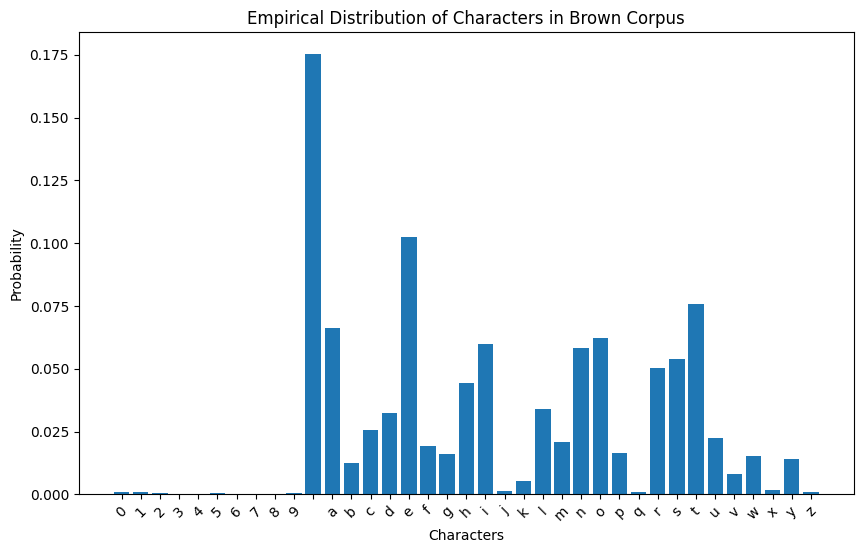

In [7]:
def compute_empirical_distribution(text):
    # count the occurrences of each character
    char_counts = {char: text.count(char) for char in alphanumeric_chars}
    
    # calc total number of characters
    total_count = sum(char_counts.values())
    
    # calc empirical distribution
    empirical_distribution = {char: count / total_count for char, count in char_counts.items()}
    
    return empirical_distribution

def compute_entropy(empirical_distribution):
    # calc entropy
    entropy = -sum(p * np.log2(p) for p in empirical_distribution.values() if p > 0) # sum over non-zero probabilities
    return entropy
    
def plot_empirical_distribution(empirical_distribution):
    # plots the empirical distribution
    plt.figure(figsize=(10, 6))
    plt.bar(empirical_distribution.keys(), empirical_distribution.values())
    plt.xlabel('Characters')
    plt.ylabel('Probability')
    plt.title('Empirical Distribution of Characters in Brown Corpus')
    plt.xticks(rotation=45)
    plt.show()

alphabet = "abcdefghijklmnopqrstuvwxyz"
empirical_distribution_brown = compute_empirical_distribution(text_brown)
entropy_brown = compute_entropy(empirical_distribution_brown)
print(f"Entropy of Brown Corpus: {entropy_brown:.2f} bits per character")
# plot
plot_empirical_distribution(empirical_distribution_brown)

Claude Shannon also computed this number (for a different corpus) and published it in a manuscript called [Prediction and Entropy of Printed English](https://www.princeton.edu/~wbialek/rome/refs/shannon_51.pdf) in 1951.  His estimate can be found in the table on p. 54, under the column header $F_1$ (the outcome of the previous section would be under column header $F_a$.  Compare your result to his and comment on potential reasons for any deviations.  

---
My answer is the same: 4.14

---

## Part 3: Joint entropy over bigrams
Obviously the distribution over the usage of characters in English is less random than uniform - but ultimately language is determined by the relationships between letters rather than the letters in isolation.  As such, let's explore a bigram model, which is to say, we'll be dealing with the distribution over two-letter pairs:
$$P(X_1,X_2).$$
First, if we were to assume that $X_1$ and $X_2$ were independent of one another (of course they aren't in reality), what would be the joint entropy of $X_1$ and $X_2$? *Note that you shouldn't have to do much to get this - the answer is an immediate consequence of your response to Part 2.* Again, this serves as an upper bound on the true joint entropy.

---
Answer: The joint entropy of $X_1$ and $X_2$ is the sum of the entropies of the two variabless, which is equal to 8.28 bits.  This is an upper bound on the true joint entropy.

---

Next, let's compute the actual joint entropy given the text corpus.  To compute this, you will need to first determine the empirical joint distribution over all possible bigrams (of which there are $37^2$).  How you organize these is up to you.  With this distribution in hand, compute the joint entropy $H(X_1,X_2)$.  How does this compare to the baseline assuming independence?

Joint Entropy of Brown Corpus: 7.53 bits per character


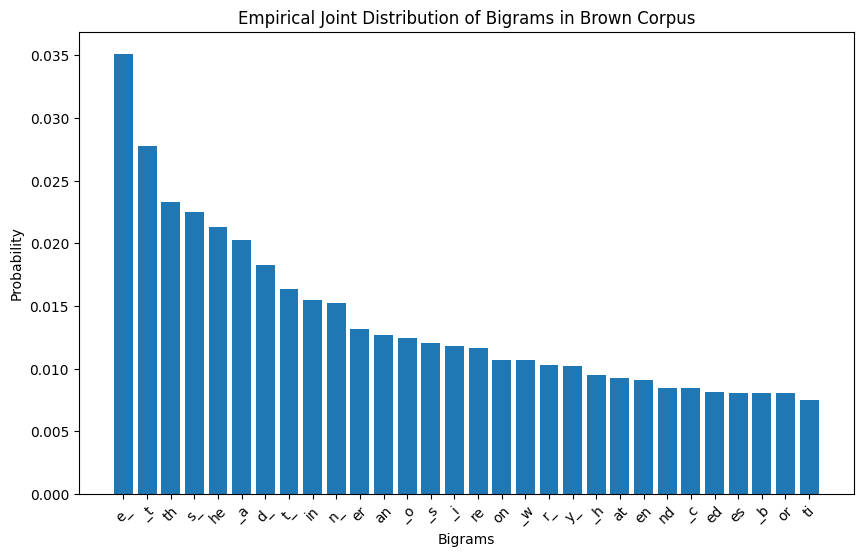

In [8]:
def compute_empirical_joint_distribution(text):
    # count the occurrences of each bigram
    bigram_counts = {}
    for i in range(len(text) - 1):
        bigram = text[i:i + 2]
        if len(bigram) == 2:
            if bigram not in bigram_counts:
                bigram_counts[bigram] = 0
            bigram_counts[bigram] += 1
    
    # calc total number of bigrams
    total_count = sum(bigram_counts.values())
    
    # calc empirical joint distribution
    empirical_joint_distribution = {bigram: count / total_count for bigram, count in bigram_counts.items()}
    
    return empirical_joint_distribution, bigram_counts
def compute_joint_entropy(empirical_joint_distribution):
    # calc joint entropy (same as before)
    joint_entropy = -sum(p * np.log2(p) for p in empirical_joint_distribution.values() if p > 0) # sum over non-zero probabilities
    return joint_entropy
def plot_empirical_joint_distribution(empirical_joint_distribution):
    # plots the empirical joint distribution
    # replace spaces with '_'
    temp_empirical_joint_distribution = {bigram.replace(' ', '_'): prob for bigram, prob in empirical_joint_distribution.items()}
    # plot the top N bigrams only
    n_top = 30
    sorted_bigrams = sorted(temp_empirical_joint_distribution.items(), key=lambda x: x[1], reverse=True)[:n_top]
    bigrams, probabilities = zip(*sorted_bigrams)
    plt.figure(figsize=(10, 6))
    plt.bar(bigrams, probabilities)
    plt.xlabel('Bigrams')
    plt.ylabel('Probability')
    plt.title('Empirical Joint Distribution of Bigrams in Brown Corpus')
    plt.xticks(rotation=45)
    plt.show()

empirical_joint_distribution_brown, bigrams = compute_empirical_joint_distribution(text_brown)
joint_entropy_brown = compute_joint_entropy(empirical_joint_distribution_brown)
print(f"Joint Entropy of Brown Corpus: {joint_entropy_brown:.2f} bits per character")
# plot
plot_empirical_joint_distribution(empirical_joint_distribution_brown)

## Part 4: Conditional entropy over bigrams
The next natural question to ask is: how predictable is the the next word ($X_2$) given knowledge the previous one ($X_1$)?  This is precisely the answer given by the conditional entropy
$$ H(X_2|X_1) = \sum_{x_1\in\mathcal{X}} P(X=x_1) H(X_2 | X_1=x_1).$$
**Develop a method to compute the conditional entropy**.  Compare your result to Shannon, whose calculation is shown in his table under the column heading $F_2$.  

*Note that you can also check to ensure that your code is functioning properly by using the identity
$$
H(X_1,X_2) = H(X_2|X_1) + H(X_1).
$$
You computed both of the quantities on the right hand side previously, so it should be trivial to ensure that this equality holds.*

In [9]:
def compute_conditional_entropy(empirical_joint_distribution, empirical_distribution):
    # calc conditional entropy
    conditional_entropy = {}
    for bigram, p_xy in empirical_joint_distribution.items():
        x1 = bigram[0]
        p_x1 = empirical_distribution[x1]
        if p_x1 > 0:
            # calculate the entropy for the bigram
            conditional_entropy[bigram] = -p_xy * np.log2(p_xy / p_x1)
    
    # sum over all bigrams
    conditional_entropy_sum = sum(conditional_entropy.values())
    
    return conditional_entropy_sum

conditional_entropy_brown = compute_conditional_entropy(empirical_joint_distribution_brown, empirical_distribution_brown)
# sanity check
print(f"Conditional Entropy: {conditional_entropy_brown:.2f} bits per character")
print(f"Joint Entropy: {joint_entropy_brown:.2f} bits per character")
print(f"Single Character Entropy: {entropy_brown:.2f} bits per character")
print(f"Conditional Entropy = Joint Entropy - Single Character Entropy: {joint_entropy_brown - entropy_brown:.2f} bits per character")

Conditional Entropy: 3.39 bits per character
Joint Entropy: 7.53 bits per character
Single Character Entropy: 4.14 bits per character
Conditional Entropy = Joint Entropy - Single Character Entropy: 3.39 bits per character


## Part 5: Mutual Information
Exactly how many bits of information does knowing the first letter provide me about the second letter?  Compute the mutual information in two ways: first, using the definition based on the Kullback-Leibler divergence:
$$I(X_1;X_2) = \sum_{x_1\in\mathcal{X}} \sum_{x_2\in\mathcal{X}} P(x_1,x_2) \lg \frac{P(x_1,x_2)}{P(x_1)P(x_2)} $$ 

In [10]:
# first
def compute_mutual_information(empirical_joint_distribution, empirical_distribution):
    # calc mutual information
    mutual_information = 0
    # formula:
    # where H(X) = entropy of X, H(Y) = entropy of Y, H(X,Y) = joint entropy of X and Y
    # mutual information = sum(p_xy * log2(p_xy / (p_x1 * p_x2)))
    # where p_xy = joint probability of X and Y, p_x1 = marginal probability of X, p_x2 = marginal probability of Y
    # p_xy = empirical_joint_distribution[bigram]
    # p_x1 = empirical_distribution[x1]
    # p_x2 = empirical_distribution[x2]
    # mutual_information = sum(p_xy * log2(p_xy / (p_x1 * p_x2)))
    # where bigram = (x1, x2)
    for bigram, p_xy in empirical_joint_distribution.items():
        x1 = bigram[0]
        x2 = bigram[1]
        p_x1 = empirical_distribution[x1]
        p_x2 = empirical_distribution[x2]
        if p_x1 > 0 and p_x2 > 0:
            mutual_information += p_xy * np.log2(p_xy / (p_x1 * p_x2))
    
    return mutual_information
mutual_information_brown = compute_mutual_information(empirical_joint_distribution_brown, empirical_distribution_brown)
print(f"Mutual Information of Brown Corpus (KL defined): {mutual_information_brown:.2f} bits per character")

Mutual Information of Brown Corpus (KL defined): 0.75 bits per character


and second using the identity 
$$ I(X_1;X_2) = H(X_2) - H(X_2 | X_1)$$ 

In [11]:
# second
def compute_mutual_info_identity(empirical_joint_distribution, empirical_distribution):
    # calc mutual information
    mutual_information = 0
    # formula:
    # I(X_1;X_2) = H(X_2) - H(X_2 | X_1)
    # where H(X_1) = entropy of X_1, H(X_2) = entropy of X_2, H(X_2 | X_1) = conditional entropy of X_2 given X_1
    mutual_information = compute_entropy(empirical_distribution) - compute_conditional_entropy(empirical_joint_distribution, empirical_distribution)
    
    return mutual_information
mutual_information_brown_identity = compute_mutual_info_identity(empirical_joint_distribution_brown, empirical_distribution_brown)
print(f"Mutual Information of Brown Corpus (Identity): {mutual_information_brown_identity:.2f} bits per character")

Mutual Information of Brown Corpus (Identity): 0.75 bits per character


## Part 6: Kullback-Leibler Divergence
Recall that there is a close relationship between the entropy of a random variable and the most efficient way in which that random variable can be encoded as a binary sequence.  The Kullback-Leibler divergence
$$
D(P(X) || Q(X)) = \sum_{x\in\mathcal{X}} P(x) \lg \frac{P(x)}{Q(x)}
$$
measures the inefficiency (measured in extra bits) of encoding a distribution $P(X)$ with a distribution designed for $Q(X)$.  We have already seen the KL-divergence applied to answering the question "how much efficiency do we lose by assuming independence", but we can use this more generally.  In particular, please answer the question: "how many extra bits do I lose by encoding Spanish characters using a code optimized for English?"  Stated alternatively, **what is the KL-divergence between $P(X)$ - defined as the unigram distribution computed from the English corpus that we've already been working with - and $Q(X)$ - defined as the unigram distribution computed from a Spanish corpus** (please find a Spanish corpus in the following code snippet).  

In [12]:
spanish_corpus = process_nltk_corpus(cess_esp)

# measure KL divergence
def compute_kl_divergence(empirical_distribution_1, empirical_distribution_2):
    kl_divergence = 0
    for char in empirical_distribution_1.keys():
        if empirical_distribution_1[char] > 0 and empirical_distribution_2[char] > 0:
            kl_divergence += empirical_distribution_1[char] * np.log2(empirical_distribution_1[char] / empirical_distribution_2[char])
    return kl_divergence
empirical_distribution_spanish = compute_empirical_distribution(spanish_corpus)
kl_divergence_brown_spanish = compute_kl_divergence(empirical_distribution_brown, empirical_distribution_spanish)
print(f"KL Divergence between Brown Corpus and Spanish Corpus: {kl_divergence_brown_spanish:.2f} bits per character")

KL Divergence between Brown Corpus and Spanish Corpus: 0.23 bits per character


Comment on your result, in particular whether it says anything on the universality of language.  Do you think your result would change if you considered joint distributions rather than univariate ones?

# Huffman Coding
### (no need to work on this part quite yet - we will get there soon)
We are already familiar with Huffman codes: they are the binary sequences of answers that optimally encode a random variable (optimal with respect to minimizing expected number of questions), and as such are deeply tied to entropy.  **Create a method that builds the Huffman coding tree given a sequence of characters.**  *You will want to build some simple test cases to ensure correct functionality*.  Once you are sure that your method is working, construct the Huffman coding tree for the Brown corpus described above.  

In [13]:
char_counts_brown = {char: text_brown.count(char) for char in alphanumeric_chars}

In [14]:
char_counts_brown

{'0': 4458,
 '1': 5182,
 '2': 2621,
 '3': 1732,
 '4': 1452,
 '5': 2144,
 '6': 1451,
 '7': 1065,
 '8': 1265,
 '9': 2125,
 ' ': 1013318,
 'a': 382803,
 'b': 72804,
 'c': 147210,
 'd': 188295,
 'e': 593146,
 'f': 110672,
 'g': 92584,
 'h': 257234,
 'i': 345755,
 'j': 7756,
 'k': 31179,
 'l': 196146,
 'm': 120641,
 'n': 336706,
 'o': 360287,
 'p': 95932,
 'q': 5103,
 'r': 291000,
 's': 310753,
 't': 438960,
 'u': 128799,
 'v': 47261,
 'w': 89140,
 'x': 9435,
 'y': 81774,
 'z': 4553}

In [15]:
heap_test = [[weight, [char, ""]] for char, weight in char_counts_brown.items()] # creates a list of lists (psuedo nodes) a la heapq

In [16]:
heap_test

[[4458, ['0', '']],
 [5182, ['1', '']],
 [2621, ['2', '']],
 [1732, ['3', '']],
 [1452, ['4', '']],
 [2144, ['5', '']],
 [1451, ['6', '']],
 [1065, ['7', '']],
 [1265, ['8', '']],
 [2125, ['9', '']],
 [1013318, [' ', '']],
 [382803, ['a', '']],
 [72804, ['b', '']],
 [147210, ['c', '']],
 [188295, ['d', '']],
 [593146, ['e', '']],
 [110672, ['f', '']],
 [92584, ['g', '']],
 [257234, ['h', '']],
 [345755, ['i', '']],
 [7756, ['j', '']],
 [31179, ['k', '']],
 [196146, ['l', '']],
 [120641, ['m', '']],
 [336706, ['n', '']],
 [360287, ['o', '']],
 [95932, ['p', '']],
 [5103, ['q', '']],
 [291000, ['r', '']],
 [310753, ['s', '']],
 [438960, ['t', '']],
 [128799, ['u', '']],
 [47261, ['v', '']],
 [89140, ['w', '']],
 [9435, ['x', '']],
 [81774, ['y', '']],
 [4553, ['z', '']]]

In [17]:
heap_test.sort()
heap_test

[[1065, ['7', '']],
 [1265, ['8', '']],
 [1451, ['6', '']],
 [1452, ['4', '']],
 [1732, ['3', '']],
 [2125, ['9', '']],
 [2144, ['5', '']],
 [2621, ['2', '']],
 [4458, ['0', '']],
 [4553, ['z', '']],
 [5103, ['q', '']],
 [5182, ['1', '']],
 [7756, ['j', '']],
 [9435, ['x', '']],
 [31179, ['k', '']],
 [47261, ['v', '']],
 [72804, ['b', '']],
 [81774, ['y', '']],
 [89140, ['w', '']],
 [92584, ['g', '']],
 [95932, ['p', '']],
 [110672, ['f', '']],
 [120641, ['m', '']],
 [128799, ['u', '']],
 [147210, ['c', '']],
 [188295, ['d', '']],
 [196146, ['l', '']],
 [257234, ['h', '']],
 [291000, ['r', '']],
 [310753, ['s', '']],
 [336706, ['n', '']],
 [345755, ['i', '']],
 [360287, ['o', '']],
 [382803, ['a', '']],
 [438960, ['t', '']],
 [593146, ['e', '']],
 [1013318, [' ', '']]]

In [18]:
lo = heap_test.pop(0)
hi = heap_test.pop(0)
# assign binary codes to the characters
# lo[1:] is the list of characters in the left subtree 
# hi[1:] is the list of characters in the right subtree
# lo[0] is the weight of the left subtree, hi[0] is the weight of the right subtree
print("lo: ", lo)
print("hi: ", hi)
for pair in lo[1:]:
    pair[1] = '0' + pair[1] # add '0' to the binary code of the characters in the left subtree
for pair in hi[1:]: 
    pair[1] = '1' + pair[1] # add '1' to the binary code of the characters in the right subtree
print("lo after: ", lo)
print("hi after: ", hi)
# the new node is the sum of the two smallest nodes
new_node = [lo[0] + hi[0]] + lo[1:] + hi[1:]
print("new_node: ", new_node)
heap_test.append(new_node) # add the new node to the heap, with the key being the sum of the two smallest nodes, and the value being the list of characters in the left and right subtrees
heap_test.sort() # sort again to maintain the lowest weight at the top
heap_test

lo:  [1065, ['7', '']]
hi:  [1265, ['8', '']]
lo after:  [1065, ['7', '0']]
hi after:  [1265, ['8', '1']]
new_node:  [2330, ['7', '0'], ['8', '1']]


[[1451, ['6', '']],
 [1452, ['4', '']],
 [1732, ['3', '']],
 [2125, ['9', '']],
 [2144, ['5', '']],
 [2330, ['7', '0'], ['8', '1']],
 [2621, ['2', '']],
 [4458, ['0', '']],
 [4553, ['z', '']],
 [5103, ['q', '']],
 [5182, ['1', '']],
 [7756, ['j', '']],
 [9435, ['x', '']],
 [31179, ['k', '']],
 [47261, ['v', '']],
 [72804, ['b', '']],
 [81774, ['y', '']],
 [89140, ['w', '']],
 [92584, ['g', '']],
 [95932, ['p', '']],
 [110672, ['f', '']],
 [120641, ['m', '']],
 [128799, ['u', '']],
 [147210, ['c', '']],
 [188295, ['d', '']],
 [196146, ['l', '']],
 [257234, ['h', '']],
 [291000, ['r', '']],
 [310753, ['s', '']],
 [336706, ['n', '']],
 [345755, ['i', '']],
 [360287, ['o', '']],
 [382803, ['a', '']],
 [438960, ['t', '']],
 [593146, ['e', '']],
 [1013318, [' ', '']]]

In [19]:
def build_huffman_tree(text):

    # count the occurrences of each character
    char_counts = {char: text.count(char) for char in alphanumeric_chars}
    
    # create a priority queue (min-heap) of nodes from scratch
    # each node is a list of two elements: [weight, [char, code]]
    # where weight is the frequency of the character, char is the character, and code is the binary code
    # the code is initially empty, it is filled in as we iterate through the pairs
    heap = [[weight, [char, ""]] for char, weight in char_counts.items()]
    heap.sort() # this give us a min-heap with the smallest weight (probability) at the top
    
    while len(heap) > 1: # while there are more than one node in the heap
        # pop the two smallest nodes from the heap
        # the 'smallest' means the lowest weight (lowest probability)
        lo = heap.pop(0)
        hi = heap.pop(0)
        # assign binary codes to the characters
        # lo[1:] is the list of characters in the left subtree - t
        # hi[1:] is the list of characters in the right subtree
        # lo[0] is the weight of the left subtree
        # we iterate through the pairs in the left and right subtrees where each pair is a list of two elements: [char, code]
        for pair in lo[1:]:
            pair[1] = '0' + pair[1] # add '0' to the binary code of the characters in the left subtree
        for pair in hi[1:]: 
            pair[1] = '1' + pair[1] # add '1' to the binary code of the characters in the right subtree
        # the new node is the sum of the two smallest nodes
        # add the new node to the heap, with the key being the sum of the two smallest nodes (aka the probability of the new node), and the value being the list of characters in the left and right subtrees (binary codes)
        heap.append([lo[0] + hi[0]] + lo[1:] + hi[1:]) 
        heap.sort()
        # when the heap has only one node left, we have built the Huffman tree
        # the remaining node is the root of the tree and contains the entire tree
    
    return heap[0][1:] # return the list of characters and their binary codes (root of the tree)

In [20]:
huffman_tree = build_huffman_tree(text_brown)

In [21]:
huffman_tree

[['h', '0000'],
 ['u', '00010'],
 ['c', '00011'],
 ['e', '001'],
 ['r', '0100'],
 ['s', '0101'],
 ['n', '0110'],
 ['k', '0111000'],
 ['v', '0111001'],
 ['y', '011101'],
 ['w', '011110'],
 ['g', '011111'],
 ['i', '1000'],
 ['o', '1001'],
 ['a', '1010'],
 ['d', '10110'],
 ['l', '10111'],
 ['t', '1100'],
 ['p', '110100'],
 ['f', '110101'],
 ['m', '110110'],
 ['x', '110111000'],
 ['q', '1101110010'],
 ['1', '1101110011'],
 ['2', '11011101000'],
 ['6', '110111010010'],
 ['4', '110111010011'],
 ['j', '1101110101'],
 ['3', '110111011000'],
 ['9', '110111011001'],
 ['0', '11011101101'],
 ['5', '110111011100'],
 ['7', '1101110111010'],
 ['8', '1101110111011'],
 ['z', '11011101111'],
 ['b', '1101111'],
 [' ', '111']]

With this tree in hand, **encode the Brown corpus.**    

In [22]:
def huffman_encoding(text):

    # build the Huffman tree
    huffman_tree = build_huffman_tree(text)

    # create a dictionary to store the codes
    codes = {}
    for pair in huffman_tree:
        # by iterating over the pairs in the Huffman tree, we can get the character and its corresponding binary code
        # pair is a list of two elements: [char, code]
        char = pair[0]
        code = pair[1]
        codes[char] = code
    # encode the text using a string join operation with list comprehension (this is like a map function)
    encoded_text = ''.join(codes[char] for char in text) # for each character in the text, get its code from the dictionary and join them together
    # return the encoded text, Huffman tree, and codes
    return encoded_text, huffman_tree, codes

**Report the compression factor** (the ratio of bits required to represent the unencoded and encoded versions of the corpus).  

In [23]:
def compute_compression_factor(text, encoded_text):

    # num bits original text
    original_bits = len(text) * 8  # assuming 8 bits per character
    # num bits in the encoded text
    encoded_bits = len(encoded_text)
    # calc the compression factor
    compression_factor = original_bits / encoded_bits
    return compression_factor
# encode the text
encoded_text, huffman_tree, codes = huffman_encoding(text_brown)
# compute the compression factor
compression_factor = compute_compression_factor(text_brown, encoded_text)
print(f"Compression factor: {compression_factor:.2f}")

Compression factor: 1.92


In [25]:
encoded_text[:100]

'1100000000111111010100010101111100100101101110001110010001001101100011101111011111010010100110101101'

In [26]:
# decode the text

def huffman_decoding(encoded_text, codes):
    
    # create a reverse mapping of codes to characters
    reverse_codes = {code: char for char, code in codes.items()}
    # decode the text
    decoded_text = ""
    current_code = ""
    for bit in encoded_text: # iterate over the bits in the encoded text
        # append the bit to the current code
        current_code += bit
        if current_code in reverse_codes: # if the current code is in the reverse mapping
            # append the character to the decoded text
            decoded_text += reverse_codes[current_code]
            current_code = ""
    return decoded_text

# decode the text
decoded_text = huffman_decoding(encoded_text, codes)
# check if the decoded text is the same as the original text
if decoded_text == text_brown:
    print("Decoded text matches the original text")
else:
    print("Decoded text does not match the original text")

Decoded text matches the original text


**Report the average number of bits used to encode each symbol in the corpus**.  Compare this to the entropy that you calculated previously.  How does your Huffman coding scheme compare to the entropy (which provides the theoretical lower limit on this quantity)? 

In [27]:
def compute_average_bits_per_symbol(encoded_text, text):

    # calculate the number of bits in the encoded text
    encoded_bits = len(encoded_text)
    # calculate the number of symbols in the original text
    num_symbols = len(text)
    # calculate the average number of bits per symbol
    average_bits_per_symbol = encoded_bits / num_symbols
    return average_bits_per_symbol
# compute the average number of bits per symbol
average_bits_per_symbol = compute_average_bits_per_symbol(encoded_text, text_brown)
print(f"Average number of bits per symbol: {average_bits_per_symbol:.2f}")
# compare to entropy
print(f"Entropy of Brown Corpus: {entropy_brown:.2f} bits per character")
# compare to joint entropy
print(f"Joint Entropy of Brown Corpus: {joint_entropy_brown:.2f} bits per character")
# compare to conditional entropy
print(f"Conditional Entropy of Brown Corpus: {conditional_entropy_brown:.2f} bits per character")

Average number of bits per symbol: 4.18
Entropy of Brown Corpus: 4.14 bits per character
Joint Entropy of Brown Corpus: 7.53 bits per character
Conditional Entropy of Brown Corpus: 3.39 bits per character
